# INFO-F422 -  Statistical Foundations of Machine Learning Project 

### Talhaoui Yassin - __[yassin.talhaoui@ulb.be](mailto:yassin.talhaoui@ulb.be)__
### Oumahi Abdelmoumen - __[abdelmoumen.oumahi@ulb.be](mailto:abdelmoumen.oumahi@ulb.be)__

## Richter's Predictor: Modeling Earthquake Damage

## Placement of the seed and the different packages that will be used

In [91]:
set.seed(123)

In [ ]:
install.packages("caret")
install.packages("tidyverse")
install.packages("corrplot")
install.packages("rpart")
install.packages("rpart.plot")
install.packages("matrixStats")
install.packages("MLmetrics")

In [93]:
library(caret)
library(tidyverse)
library(corrplot)
library(rpart)
library(rpart.plot)
library(matrixStats)
library(MLmetrics)

## QUESTION 1

Loading of different datasets and first overview of the data

In [217]:
train <- read.csv("Richters_Predictor_Modeling_Earthquake_Damage_-_Train_Values.csv")
label <- read.csv("Richters_Predictor_Modeling_Earthquake_Damage_-_Train_Labels.csv")
test <- read.csv("Richters_Predictor_Modeling_Earthquake_Damage_-_Test_Values.csv")
trainMerged <- inner_join(train, label, by='building_id')
dim(train)
dim(label)
dim(test)
dim(trainMerged)

[1] 260601     39

[1] 260601      2

[1] 86868    39

[1] 260601     40

The dimensions are in accordance with the one stated on the DivenData website

In [ ]:
head(train)
head(trainMerged)
head(label)

In [ ]:
summary(train)
summary(label)
summary(test)

And by using the summary() function of R, we can affirm that there is no missing value.

Here the objective is to try to reduce the impact of extreme values of some variables. For example the variable "age" contains some very high values (building which are almost 1000 years old), in order to avoid that it impacts the accuracy of our tasks. We will reduce them by replacing them by limit values (Winsorization)

Count_floors_pre_eq

In [218]:
iqr <- IQR(trainMerged$count_floors_pre_eq)
factor <- 3
limit <- median(trainMerged$count_floors_pre_eq) + factor * iqr
trainMerged$count_floors_pre_eq[trainMerged$count_floors_pre_eq > limit] <- limit

iqr <- IQR(test$count_floors_pre_eq)
factor <- 3
limit <- median(test$count_floors_pre_eq) + factor * iqr
test$count_floors_pre_eq[test$count_floors_pre_eq > limit] <- limit

In [ ]:
hist(trainMerged$count_floors_pre_eq)
table(trainMerged$count_floors_pre_eq)

Age

In [219]:
iqr <- IQR(trainMerged$age)
factor <- 3
limit <- median(trainMerged$age) + factor * iqr
trainMerged$age[trainMerged$age > limit] <- limit

iqr <- IQR(test$age)
factor <- 3
limit <- median(test$age) + factor * iqr
test$age[test$age > limit] <- limit

In [ ]:
hist(trainMerged$age)
table(trainMerged$age)


Area_percentage

In [220]:
iqr <- IQR(trainMerged$area_percentage)
factor <- 3
limit <- median(trainMerged$area_percentage) + factor * iqr
trainMerged$area_percentage[trainMerged$area_percentage > limit] <- limit

iqr <- IQR(test$area_percentage)
factor <- 3
limit <- median(test$area_percentage) + factor * iqr
test$area_percentage[test$area_percentage > limit] <- limit

In [ ]:
hist(trainMerged$area_percentage)
table(trainMerged$area_percentage)

Height_percentage

In [221]:
iqr <- IQR(trainMerged$height_percentage)
factor <- 1.5
limit <- median(trainMerged$height_percentage) + factor * iqr
trainMerged$height_percentage[trainMerged$height_percentage > limit] <- limit

iqr <- IQR(test$height_percentage)
factor <- 1.5
limit <- median(test$height_percentage) + factor * iqr
test$height_percentage[test$height_percentage > limit] <- limit

In [ ]:
hist(trainMerged$height_percentage)
table(trainMerged$height_percentage)

Count_families

In [222]:
iqr <- IQR(trainMerged$count_families)
factor <- 1.5
limit <- median(trainMerged$count_families) + factor * iqr
trainMerged$count_families[trainMerged$count_families > limit] <- limit

iqr <- IQR(test$count_families)
factor <- 1.5
limit <- median(test$count_families) + factor * iqr
test$count_families[test$count_families > limit] <- limit

In [ ]:
hist(trainMerged$count_families)
table(trainMerged$count_families)

We also set up some more graphs in order to have a first idea about the relation between our target variable (damage_grade) and our variables

In [104]:
bar_plot_stat <- function(data1, data2, name) {
    T <- table(data1, data2)
    Prop <- T/rowSums(T)
    barplot(t(Prop), horiz=TRUE, col=rainbow(3), main=name, las=1, cex.names = 0.6)
}

In [ ]:
for (i in colnames(trainMerged[5:39])) {
    bar_plot_stat(trainMerged[, i], trainMerged$damage_grade, i)
}

Next step we have a number of variables that are categorical, this may be bad for the steps that follow so we will use the one hot encoding to make them numeric.

Step 1: we detect the variables to modify

In [223]:
character_variables_bool<-sapply(trainMerged[1,],class)=="character"
character_variables_boolT<-sapply(test[1,],class)=="character"
character_variables_bool

building_id                         geo_level_1_id 
                                 FALSE                                  FALSE 
                        geo_level_2_id                         geo_level_3_id 
                                 FALSE                                  FALSE 
                   count_floors_pre_eq                                    age 
                                 FALSE                                  FALSE 
                       area_percentage                      height_percentage 
                                 FALSE                                  FALSE 
                land_surface_condition                        foundation_type 
                                  TRUE                                   TRUE 
                             roof_type                      ground_floor_type 
                                  TRUE                                   TRUE 
                      other_floor_type                               position 
                                  TRUE                                   TRUE 
                    plan_configuration           has_superstructure_adobe_mud 
                                  TRUE                                  FALSE 
   has_superstructure_mud_mortar_stone          has_superstructure_stone_flag 
                                 FALSE                                  FALSE 
has_superstructure_cement_mortar_stone    has_superstructure_mud_mortar_brick 
                                 FALSE                                  FALSE 
has_superstructure_cement_mortar_brick              has_superstructure_timber 
                                 FALSE                                  FALSE 
             has_superstructure_bamboo   has_superstructure_rc_non_engineered 
                                 FALSE                                  FALSE 
      has_superstructure_rc_engineered               has_superstructure_other 
                                 FALSE                                  FALSE 
                legal_ownership_status                         count_families 
                                  TRUE                                  FALSE 
                     has_secondary_use          has_secondary_use_agriculture 
                                 FALSE                                  FALSE 
               has_secondary_use_hotel               has_secondary_use_rental 
                                 FALSE                                  FALSE 
         has_secondary_use_institution               has_secondary_use_school 
                                 FALSE                                  FALSE 
            has_secondary_use_industry          has_secondary_use_health_post 
                                 FALSE                                  FALSE 
          has_secondary_use_gov_office           has_secondary_use_use_police 
                                 FALSE                                  FALSE 
               has_secondary_use_other                           damage_grade 
                                 FALSE                                  FALSE

In [224]:
character_variables <- which(sapply(trainMerged[1,],class)=="character")
character_variablesT <- which(sapply(test[1,],class)=="character")
character_variables
length(character_variables)

land_surface_condition        foundation_type              roof_type 
                     9                     10                     11 
     ground_floor_type       other_floor_type               position 
                    12                     13                     14 
    plan_configuration legal_ownership_status 
                    15                     27

[1] 8

In [225]:
data_preprocessed<-trainMerged[,-character_variables]
data_preprocessedT<-test[,-character_variablesT]
dim(data_preprocessed)


[1] 260601     32

In [ ]:
head(data_preprocessed)

In [226]:
data_normalise <- scale(data_preprocessed[, c("geo_level_1_id", "geo_level_2_id", "geo_level_3_id" )])
data_normaliseT <- scale(data_preprocessedT[, c("geo_level_1_id", "geo_level_2_id", "geo_level_3_id" )])


In [227]:
data_preprocessed[, c("geo_level_1_id", "geo_level_2_id", "geo_level_3_id")] <- data_normalise[, c("geo_level_1_id", "geo_level_2_id", "geo_level_3_id" )]
data_preprocessedT[, c("geo_level_1_id", "geo_level_2_id", "geo_level_3_id")] <- data_normaliseT[, c("geo_level_1_id", "geo_level_2_id", "geo_level_3_id" )]

In [ ]:
head(data_preprocessed)

Step 2: We apply the one hot encoding for these variables

In [228]:
cols_to_transform <- c("land_surface_condition", "foundation_type", "roof_type",
                       "ground_floor_type", "other_floor_type", "position", 
                       "plan_configuration", "legal_ownership_status")

one_hot_trans <- dummyVars(formula = ~ ., data = trainMerged[, cols_to_transform])

data_one_hot <- data.frame(predict(one_hot_trans, newdata = trainMerged))

In [229]:
cols_to_transformT <- c("land_surface_condition", "foundation_type", "roof_type",
                       "ground_floor_type", "other_floor_type", "position", 
                       "plan_configuration", "legal_ownership_status")

one_hot_transT <- dummyVars(formula = ~ ., data = test[, cols_to_transformT])

data_one_hotT <- data.frame(predict(one_hot_transT, newdata = test))

Step 3 : We merge our modified varibale with our dataset in order to obtain a table with only numeric values

In [230]:
trainCleaned <- cbind(data_preprocessed, data_one_hot)
trainCleanedT <- cbind(data_preprocessedT, data_one_hotT)
head(trainCleaned)


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,plan_configurationm,plan_configurationn,plan_configurationo,plan_configurationq,plan_configurations,plan_configurationu,legal_ownership_statusa,legal_ownership_statusr,legal_ownership_statusv,legal_ownership_statusw
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,802906,-0.9834118,-0.5187039,1.6290515,2,30,6,5,1,1,...,0,0,0,0,0,0,0,0,1,0
2,28830,-0.7344579,0.4819970,-0.9450156,2,10,8,7,0,1,...,0,0,0,0,0,0,0,0,1,0
3,94947,0.8837423,-0.8191565,0.7446102,2,10,5,5,0,1,...,0,0,0,0,0,0,0,0,1,0
4,590882,1.0082192,-0.6858913,1.2165864,2,10,6,5,0,1,...,0,0,0,0,0,0,0,0,1,0
5,201944,-0.3610271,-1.3812936,-1.3081165,2,30,8,8,1,0,...,0,0,0,0,0,0,0,0,1,0
6,333020,-0.7344579,-0.3466706,-0.0463135,2,10,9,5,0,1,...,0,0,0,0,0,0,0,0,1,0


Moreover, we remove the building_id varibles which will not bring anything during the following steps.

In [231]:
trainCleaned <- trainCleaned %>% relocate(damage_grade, .after = legal_ownership_statusw)
trainCleaned <- select(trainCleaned, -c(building_id))
trainCleanedT <- select(trainCleanedT, -c(building_id))
head(trainCleaned)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,plan_configurationn,plan_configurationo,plan_configurationq,plan_configurations,plan_configurationu,legal_ownership_statusa,legal_ownership_statusr,legal_ownership_statusv,legal_ownership_statusw,damage_grade
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,-0.9834118,-0.5187039,1.6290515,2,30,6,5,1,1,0,...,0,0,0,0,0,0,0,1,0,3
2,-0.7344579,0.4819970,-0.9450156,2,10,8,7,0,1,0,...,0,0,0,0,0,0,0,1,0,2
3,0.8837423,-0.8191565,0.7446102,2,10,5,5,0,1,0,...,0,0,0,0,0,0,0,1,0,3
4,1.0082192,-0.6858913,1.2165864,2,10,6,5,0,1,0,...,0,0,0,0,0,0,0,1,0,2
5,-0.3610271,-1.3812936,-1.3081165,2,30,8,8,1,0,0,...,0,0,0,0,0,0,0,1,0,3
6,-0.7344579,-0.3466706,-0.0463135,2,10,9,5,0,1,0,...,0,0,0,0,0,0,0,1,0,2


In order to have a first vision of the correlation between the variables we set up a correlation matrix.

In [ ]:
numeric_data = c()
for (i in 1:ncol(trainCleaned)) {
    if (class(trainCleaned[, i]) != "character") {
        numeric_data <- append(numeric_data, i)
    }
}
cormat <- abs(cor(trainCleaned[, numeric_data]))
cormat

Graphical view of our correlation matrix 

In [ ]:
cormat <- abs(cor(trainCleaned))
corrplot(cormat, tl.cex = 0.1, method = "color")


The large number of variables makes the matrix and the graph not very readable (even if the graph gives us some points of strong correlation)
We will now, from a preprocessing perspective, remove all variables for which the correlation factor is > 0.5 and then we will keep the best feature between the two.
For this we calculate the best feature is the feature for which the correlation with our target feature (damage_grade) is the highest.

Then we will remove them from our dataset. One of the other reasons is that by leaving all the variables present in our dataset, the too big number will systematically lead to an error because of the too big load of the operation (limit of technique of my computer I think)

In [239]:
to_delete_DG = c()
for (i in 1:(nrow(cormat)-1)) {
    for (j in i:(nrow(cormat)-1)) {
        if (cormat[i,j] > 0.6 &  i!=j) {
            if (abs(cormat[i,69]) < abs(cormat[j,69])) {
                to_delete_DG <- c(to_delete_DG, i)
            } else {
                to_delete_DG <- c(to_delete_DG, j)
            }
        }
    }
}
to_delete_DG <- to_delete_DG[!duplicated(to_delete_DG)]
to_delete_DG


[1]  7 47 21 31 35 49 40 41 42 45 53 62 67

In [240]:
trainCleanedD <- select(trainCleaned,-c(to_delete_DG))
head(trainCleanedD)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,...,plan_configurationf,plan_configurationm,plan_configurationn,plan_configurationo,plan_configurations,plan_configurationu,legal_ownership_statusa,legal_ownership_statusr,legal_ownership_statusw,damage_grade
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,-0.9834118,-0.5187039,1.6290515,2,30,6,1,1,0,0,...,0,0,0,0,0,0,0,0,0,3
2,-0.7344579,0.4819970,-0.9450156,2,10,8,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0.8837423,-0.8191565,0.7446102,2,10,5,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3
4,1.0082192,-0.6858913,1.2165864,2,10,6,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2
5,-0.3610271,-1.3812936,-1.3081165,2,30,8,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3
6,-0.7344579,-0.3466706,-0.0463135,2,10,9,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2


In [241]:
trainCleanedDT <- select(trainCleanedT,-c(to_delete_DG))
head(trainCleanedDT)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,...,plan_configurationd,plan_configurationf,plan_configurationm,plan_configurationn,plan_configurationo,plan_configurations,plan_configurationu,legal_ownership_statusa,legal_ownership_statusr,legal_ownership_statusw
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.3875425,-0.2615809,1.3827458,2,20,7,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,-0.9823929,-1.3623056,1.5691129,2,25,13,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
3,1.0102404,-1.6574450,1.0365963,2,5,4,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1.5083988,-1.6090615,-1.5426699,1,0,19,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,0.3875425,-1.0042677,0.4681765,2,15,8,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
6,1.0102404,-1.2921495,-0.6119306,1,55,4,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


The previous steps concern feature engineering and data verification, now we will move to the feature selection step.

We are going to use methods known as filtering as stated in the tp of the course they are methods of preprocessing. 

They seek to evaluate the benefits of data features without considering the effects of the selected feature subset on the performance of the learning algorithm. These methods select variables by ordering them using compression techniques such as principal component analysis (PCA) or by computing their correlation or a more advanced similarity measure such as minimum redundancy and maximum relevance (mRMR) to the output.

We will use the last two methods to make our feature selection

Concerning the script of the "Correlation with the output" and "mRMR" we use the same as the TP 5 of the courses 

In [242]:
X<-trainCleanedD[,setdiff(colnames(trainCleanedD),"damage_grade")]
Y<-trainCleanedD[,"damage_grade"]
N <-nrow(X)
n <-ncol(X)

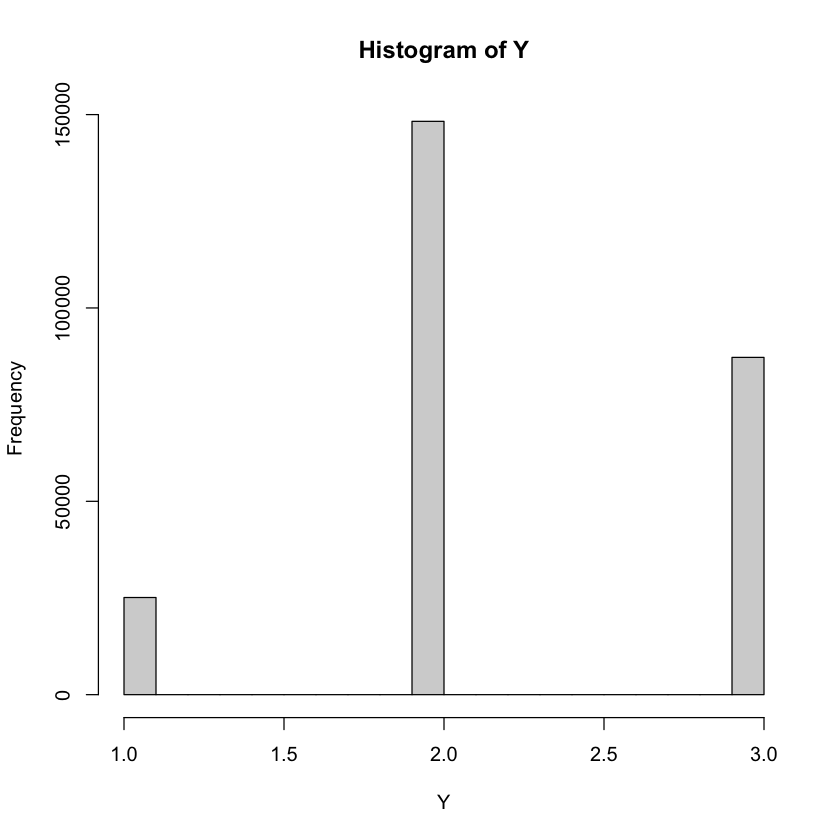

In [132]:
hist(Y)

Correlation with the output

In [243]:
CV_folds <- 10

size_CV <-floor(N/CV_folds)

CV_err<-matrix(0,nrow=n,ncol=CV_folds)

for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Compute correlation across all the input variables and the target variable
    correlation_vector <-abs(cor(X_tr,Y_tr))
    # Rank variables according to correlation with the output
    correlation_ranking_idx <-sort(correlation_vector,dec=T,index.return=T)$ix
     
    for (nb_features in 1:n) {
        # Create a dataset including only the nb_features most correlated variables with the output
        DS<-cbind(X_tr[,correlation_ranking_idx[1:nb_features],drop=F],damage_grade=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(damage_grade~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,correlation_ranking_idx[1:nb_features],drop=F])
        
        # Cross validation error = MSE
        CV_err[nb_features,i] <- mean((Y_hat_ts-Y_ts)^2)
    }
}  

print(paste("#Features: ",c(1:n)," ; CV error=",round(apply(CV_err,1,mean),digits=4), " ; std dev=",round(apply(CV_err,1,sd),digits=4)))

 [1] "#Features:  1  ; CV error= 0.3302  ; std dev= 0.0022" 
 [2] "#Features:  2  ; CV error= 0.3199  ; std dev= 0.0019" 
 [3] "#Features:  3  ; CV error= 0.3174  ; std dev= 0.0019" 
 [4] "#Features:  4  ; CV error= 0.3169  ; std dev= 0.0019" 
 [5] "#Features:  5  ; CV error= 0.3161  ; std dev= 0.0018" 
 [6] "#Features:  6  ; CV error= 0.3146  ; std dev= 0.0019" 
 [7] "#Features:  7  ; CV error= 0.3146  ; std dev= 0.0018" 
 [8] "#Features:  8  ; CV error= 0.3138  ; std dev= 0.0018" 
 [9] "#Features:  9  ; CV error= 0.3122  ; std dev= 0.0018" 
[10] "#Features:  10  ; CV error= 0.3119  ; std dev= 0.0018"
[11] "#Features:  11  ; CV error= 0.3112  ; std dev= 0.0019"
[12] "#Features:  12  ; CV error= 0.3112  ; std dev= 0.0019"
[13] "#Features:  13  ; CV error= 0.3111  ; std dev= 0.0019"
[14] "#Features:  14  ; CV error= 0.311  ; std dev= 0.0019" 
[15] "#Features:  15  ; CV error= 0.311  ; std dev= 0.0019" 
[16] "#Features:  16  ; CV error= 0.3106  ; std dev= 0.0016"
[17] "#Features:  17  ; 

In [244]:
NuF1 <- correlation_ranking_idx
NaF1 <- colnames(X)[correlation_ranking_idx]
NuF1
NaF1

[1] 32 37  8 12 16 34 39 15  5 33  4  6 20 21 53 35 19  1 13  9 18 14 52 10  7
[26] 43 40 46  2 41 17 55 22 45 44 36 38 28 30 29 31 11 50 24 51 23 26 25  3 48
[51] 42 54 49 27 47

[1] "foundation_typer"                      
 [2] "ground_floor_typev"                    
 [3] "has_superstructure_mud_mortar_stone"   
 [4] "has_superstructure_cement_mortar_brick"
 [5] "has_superstructure_rc_engineered"      
 [6] "foundation_typew"                      
 [7] "other_floor_typeq"                     
 [8] "has_superstructure_rc_non_engineered"  
 [9] "age"                                   
[10] "foundation_typeu"                      
[11] "count_floors_pre_eq"                   
[12] "area_percentage"                       
[13] "has_secondary_use_hotel"               
[14] "has_secondary_use_rental"              
[15] "legal_ownership_statusa"               
[16] "roof_typen"                            
[17] "has_secondary_use"                     
[18] "geo_level_1_id"                        
[19] "has_superstructure_timber"             
[20] "has_superstructure_stone_flag"         
[21] "count_families"                        
[22] "has_superstructure_bamboo"             
[23] "plan_configurationu"                   
[24] "has_superstructure_cement_mortar_stone"
[25] "has_superstructure_adobe_mud"          
[26] "positiont"                             
[27] "other_floor_typex"                     
[28] "plan_configurationd"                   
[29] "geo_level_2_id"                        
[30] "positionj"                             
[31] "has_superstructure_other"              
[32] "legal_ownership_statusw"               
[33] "has_secondary_use_institution"         
[34] "plan_configurationc"                   
[35] "plan_configurationa"                   
[36] "ground_floor_typem"                    
[37] "ground_floor_typez"                    
[38] "has_secondary_use_other"               
[39] "land_surface_conditiont"               
[40] "land_surface_conditiono"               
[41] "foundation_typeh"                      
[42] "has_superstructure_mud_mortar_brick"   
[43] "plan_configurationo"                   
[44] "has_secondary_use_industry"            
[45] "plan_configurations"                   
[46] "has_secondary_use_school"              
[47] "has_secondary_use_gov_office"          
[48] "has_secondary_use_health_post"         
[49] "geo_level_3_id"                        
[50] "plan_configurationm"                   
[51] "positiono"                             
[52] "legal_ownership_statusr"               
[53] "plan_configurationn"                   
[54] "has_secondary_use_use_police"          
[55] "plan_configurationf"

mRMR

In [245]:
CV_folds <- 10

size_CV <-floor(N/CV_folds)

CV_err<-matrix(0,nrow=n,ncol=CV_folds)

for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Computing the correlation between input variables and output variable on the training set
    correlation<-abs(cor(X_tr,Y_tr))
    
    # Initialization : No variables are selected and all the variables are candidates
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n) {
        redundancy_score<-numeric(length(candidates))
        
        if (length(selected)>0) {
            # Compute the correlation between the selected variables and the candidates on the training set
            cor_selected_candidates<-cor(X_tr[,selected,drop=F],X_tr[,candidates,drop=F])
            # Compute the mean correlation for each candidate variable, across the selected variables
            redundancy_score<-apply(cor_selected_candidates,2,mean)
        }
        
        # mRMR: minimum Redundancy Maximum Relevancy
        mRMR_score<-correlation[candidates]-redundancy_score
        
        # Select the candidate variable that maximises the mRMR score
        selected_current<-candidates[which.max(mRMR_score)]
        selected<-c(selected,selected_current)
        
        # Remove the selected variables from the candidates
        candidates<-setdiff(candidates,selected_current)
    }
    
    ranking <- selected
     
    for (nb_features in 1:n) {
        # Create a dataset including only the first nb_features selected variables
        DS<-cbind(X_tr[,ranking[1:nb_features],drop=F],damage_grade=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(damage_grade~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,ranking[1:nb_features],drop=F])
        
        # Cross-validation error = MSE
        CV_err[nb_features,i]<-mean((Y_hat_ts-Y_ts)^2)
    }
}  

print(paste("#Features: ",c(1:n)," ; CV error=",round(apply(CV_err,1,mean),digits=4), " ; std dev=",round(apply(CV_err,1,sd),digits=4)))

 [1] "#Features:  1  ; CV error= 0.3302  ; std dev= 0.0022" 
 [2] "#Features:  2  ; CV error= 0.3199  ; std dev= 0.0019" 
 [3] "#Features:  3  ; CV error= 0.3189  ; std dev= 0.002"  
 [4] "#Features:  4  ; CV error= 0.3166  ; std dev= 0.0019" 
 [5] "#Features:  5  ; CV error= 0.3159  ; std dev= 0.002"  
 [6] "#Features:  6  ; CV error= 0.3142  ; std dev= 0.002"  
 [7] "#Features:  7  ; CV error= 0.313  ; std dev= 0.0019"  
 [8] "#Features:  8  ; CV error= 0.3129  ; std dev= 0.0019" 
 [9] "#Features:  9  ; CV error= 0.3122  ; std dev= 0.0018" 
[10] "#Features:  10  ; CV error= 0.3119  ; std dev= 0.0018"
[11] "#Features:  11  ; CV error= 0.3112  ; std dev= 0.0017"
[12] "#Features:  12  ; CV error= 0.3106  ; std dev= 0.0018"
[13] "#Features:  13  ; CV error= 0.3106  ; std dev= 0.0018"
[14] "#Features:  14  ; CV error= 0.3104  ; std dev= 0.0018"
[15] "#Features:  15  ; CV error= 0.3095  ; std dev= 0.0017"
[16] "#Features:  16  ; CV error= 0.3095  ; std dev= 0.0017"
[17] "#Features:  17  ; 

In [247]:
NuF2 <- selected
NaF2 <- colnames(X)[selected]
NuF2
NaF2

[1] 32 37 34  8 12  5 16 39 15 33 35  4  6 53 13 20  9 21 18  7  1 52 46  2 40
[26] 10 14 43 19 55 45 44 22 17 30 29 36 38 41 50 51 31 28 24 23 26  3 25 48 49
[51] 54 27 11 47 42

[1] "foundation_typer"                      
 [2] "ground_floor_typev"                    
 [3] "foundation_typew"                      
 [4] "has_superstructure_mud_mortar_stone"   
 [5] "has_superstructure_cement_mortar_brick"
 [6] "age"                                   
 [7] "has_superstructure_rc_engineered"      
 [8] "other_floor_typeq"                     
 [9] "has_superstructure_rc_non_engineered"  
[10] "foundation_typeu"                      
[11] "roof_typen"                            
[12] "count_floors_pre_eq"                   
[13] "area_percentage"                       
[14] "legal_ownership_statusa"               
[15] "has_superstructure_timber"             
[16] "has_secondary_use_hotel"               
[17] "has_superstructure_stone_flag"         
[18] "has_secondary_use_rental"              
[19] "count_families"                        
[20] "has_superstructure_adobe_mud"          
[21] "geo_level_1_id"                        
[22] "plan_configurationu"                   
[23] "plan_configurationd"                   
[24] "geo_level_2_id"                        
[25] "other_floor_typex"                     
[26] "has_superstructure_cement_mortar_stone"
[27] "has_superstructure_bamboo"             
[28] "positiont"                             
[29] "has_secondary_use"                     
[30] "legal_ownership_statusw"               
[31] "plan_configurationc"                   
[32] "plan_configurationa"                   
[33] "has_secondary_use_institution"         
[34] "has_superstructure_other"              
[35] "land_surface_conditiont"               
[36] "land_surface_conditiono"               
[37] "ground_floor_typem"                    
[38] "ground_floor_typez"                    
[39] "positionj"                             
[40] "plan_configurationo"                   
[41] "plan_configurations"                   
[42] "foundation_typeh"                      
[43] "has_secondary_use_other"               
[44] "has_secondary_use_industry"            
[45] "has_secondary_use_school"              
[46] "has_secondary_use_gov_office"          
[47] "geo_level_3_id"                        
[48] "has_secondary_use_health_post"         
[49] "plan_configurationm"                   
[50] "plan_configurationn"                   
[51] "legal_ownership_statusr"               
[52] "has_secondary_use_use_police"          
[53] "has_superstructure_mud_mortar_brick"   
[54] "plan_configurationf"                   
[55] "positiono"

In [249]:
NaF2 <- 34
selected_features <- ranking[1:NaF2] 

New_Train <- trainCleanedD[, selected_features, drop = FALSE]

# Ajoutez la variable cible si nécessaire
New_Train <- cbind(New_Train, damage_grade = Y)


In [162]:
NaF2 <- 16
selected_features <- ranking[1:NaF2] 

New_TrainT <- trainCleanedDT[, selected_features, drop = FALSE]


In [250]:
head(New_Train)

,foundation_typer,ground_floor_typev,foundation_typew,has_superstructure_mud_mortar_stone,has_superstructure_cement_mortar_brick,age,has_superstructure_rc_engineered,other_floor_typeq,has_superstructure_rc_non_engineered,foundation_typeu,...,has_superstructure_cement_mortar_stone,has_superstructure_bamboo,positiont,has_secondary_use,legal_ownership_statusw,plan_configurationc,plan_configurationa,has_secondary_use_institution,has_superstructure_other,damage_grade
,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,...,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,1,0,0,1,0,30,0,1,0,0,...,0,0,1,0,0,0,0,0,0,3
2,1,0,0,1,0,10,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2
3,1,0,0,1,0,10,0,0,0,0,...,0,0,1,0,0,0,0,0,0,3
4,1,0,0,1,0,10,0,0,0,0,...,0,1,0,0,0,0,0,0,0,2
5,1,0,0,0,0,30,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
6,1,0,0,1,0,10,0,1,0,0,...,0,0,0,1,0,0,0,0,0,2


In [ ]:
X<-New_Train[,setdiff(colnames(New_Train),"damage_grade")]
Y<-New_Train[,"damage_grade"]


N <-nrow(X)
n <-ncol(X)

## QUESTION 2

In [251]:
# from https://pastebin.com/b6WufBNq

ConfusionMatrix <- function(y_pred, y_true) {
  Confusion_Mat <- table(y_true, y_pred)
  return(Confusion_Mat)
}
 
ConfusionDF <- function(y_pred, y_true) {
  Confusion_DF <- transform(as.data.frame(ConfusionMatrix(y_pred, y_true)),
                            y_true = as.character(y_true),
                            y_pred = as.character(y_pred),
                            Freq = as.integer(Freq))
  return(Confusion_DF)
}
 
Precision_micro <- function(y_true, y_pred, labels = NULL) {
  Confusion_DF <- ConfusionDF(y_pred, y_true)
 
  if (is.null(labels) == TRUE) labels <- unique(c(y_true, y_pred))
  # this is not bulletproof since there might be labels missing (in strange cases)
  # in strange cases where they existed in training set but are missing from test ground truth and predictions.
 
  TP <- c()
  FP <- c()
  for (i in c(1:length(labels))) {
    positive <- labels[i]
   
    # it may happen that a label is never predicted (missing from y_pred) but exists in y_true
    # in this case ConfusionDF will not have these lines and thus the simplified code crashes
    # TP[i] <- as.integer(Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"])
    # FP[i] <- as.integer(sum(Confusion_DF[which(Confusion_DF$y_true!=positive & Confusion_DF$y_pred==positive), "Freq"]))
   
    # workaround:
    # i don't want to change ConfusionDF since i don't know if the current behaviour is a feature or a bug.
    tmp <- Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"]
    TP[i] <- if (length(tmp)==0) 0 else as.integer(tmp)
   
    tmp <- Confusion_DF[which(Confusion_DF$y_true!=positive & Confusion_DF$y_pred==positive), "Freq"]
    FP[i] <- if (length(tmp)==0) 0 else as.integer(sum(tmp))
  }
  Precision_micro <- sum(TP) / (sum(TP) + sum(FP))
  return(Precision_micro)
}
 
Recall_micro <- function(y_true, y_pred, labels = NULL) {
  Confusion_DF <- ConfusionDF(y_pred, y_true)
 
  if (is.null(labels) == TRUE) labels <- unique(c(y_true, y_pred))
  # this is not bulletproof since there might be labels missing (in strange cases)
  # in strange cases where they existed in training set but are missing from test ground truth and predictions.
 
  TP <- c()
  FN <- c()
  for (i in c(1:length(labels))) {
    positive <- labels[i]
   
    # short version, comment out due to bug or feature of Confusion_DF
    # TP[i] <- as.integer(Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"])
    # FP[i] <- as.integer(sum(Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred!=positive), "Freq"]))
   
    # workaround:
    tmp <- Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"]
    TP[i] <- if (length(tmp)==0) 0 else as.integer(tmp)
 
    tmp <- Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred!=positive), "Freq"]
    FN[i] <- if (length(tmp)==0) 0 else as.integer(sum(tmp))
  }
  Recall_micro <- sum(TP) / (sum(TP) + sum(FN))
  return(Recall_micro)
}
 
F1_Score_micro <- function(y_true, y_pred, labels = NULL) {
  if (is.null(labels) == TRUE) labels <- unique(c(y_true, y_pred)) # possible problems if labels are missing from y_*
  Precision <- Precision_micro(y_true, y_pred, labels)
  Recall <- Recall_micro(y_true, y_pred, labels)
  F1_Score_micro <- 2 * (Precision * Recall) / (Precision + Recall)
  return(F1_Score_micro)
}

MODEL 1 : Decision Tree

In [290]:
set.seed(10)

In [292]:
DTM <- New_Train

[1] "Training Set Size :  156360 Test set Size :  104241"


,model.variable.importance
,<dbl>
geo_level_1_id,8175.22368
foundation_typer,3411.24049
foundation_typew,1246.04175
foundation_typeu,1177.80318
ground_floor_typev,1017.00657
has_superstructure_cement_mortar_brick,636.42758
geo_level_2_id,377.22388
has_superstructure_rc_engineered,329.12338
has_superstructure_timber,319.46450


[1] "F1 Score: 0.607937375888566"
[1] "Misclassification_rate On Damage Grade Prediction =  0.392062624111434"
[1] "Accuracy On Damage Grade Prediction =  0.607937375888566"


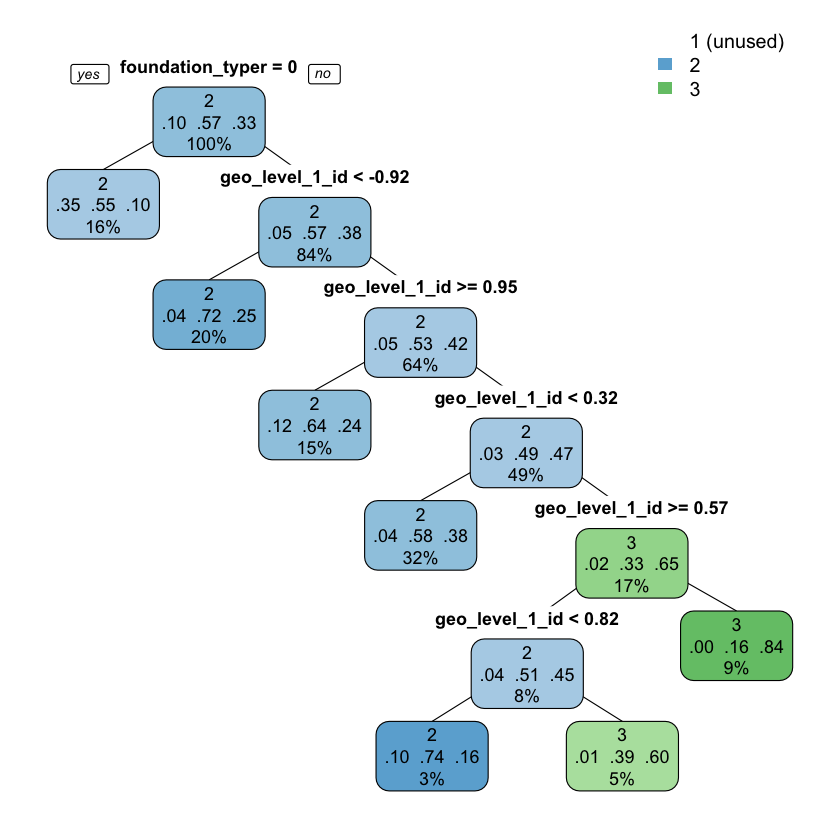

In [291]:
shuffled_index <- sample(1:nrow(DTM))
train_data_idx <- sample(1:nrow(DTM), floor(0.6 * nrow(DTM)))
train_data <- DTM[train_data_idx, ]
test_data <- DTM[-train_data_idx, ]
print(paste("Training Set Size : ",nrow(train_data) ,"Test set Size : ",nrow(test_data) ))
model <- rpart(damage_grade ~ . , method="class", data=train_data)
data.frame(model$variable.importance)
rpart.plot(model, type=1 , fallen.leaves = F ,cex =0.9)
Y_pred_probs <- predict(model, test_data[,-ncol(test_data)], type = "prob")
Y <- test_data[,ncol(test_data)]
Y_pred <- ifelse(Y_pred_probs[,1] > 0.3, "1", 
            ifelse(Y_pred_probs[,2] > 0.5, "2", "3"))
confusion_matrix <- table(Y_pred, Y)
Y_pred <- as.factor(Y_pred)
Y <- as.factor(Y)
f1_score <- F1_Score_micro(Y, Y_pred)
print(paste("F1 Score:", f1_score))
accuracy = sum(diag(confusion_matrix))/sum(confusion_matrix)
misclassification_rate = 1 - accuracy
print(paste("Misclassification_rate On Damage Grade Prediction = " , misclassification_rate))
print(paste( "Accuracy On Damage Grade Prediction = " , accuracy))

MODEL 2 : Random Forest


In [294]:
install.packages("randomForest")
library("randomForest")


Les packages binaires t'el'echarg'es sont dans
	/var/folders/7j/n3q0pxkj3fvc8pf6rq5cpq680000gn/T//RtmpvzmHz1/downloaded_packages


In [293]:
set.seed(11)

In [295]:
RFM <- New_Train

In [296]:
n_trees <- 70
accuracy_vec <- rep(0, n_trees)
f1_score_vec <- rep(0, n_trees)

class_weights <- table(RFM$damage_grade) / nrow(RFM)  # Computation of class weights

for (i in 1:n_trees) {
  # Creation of training and test sets
  train_data_idx <- sample(1:nrow(RFM), floor(0.7 * nrow(RFM)))
  train_data <- RFM[train_data_idx, ]
  test_data <- RFM[-train_data_idx, ]
  
  # Random forest model
  model <- randomForest(
    x = train_data[, -which(names(train_data) == "damage_grade")],
    y = as.factor(train_data$damage_grade),
    ntree = i,
    classwt = class_weights
  )
  
  # Predict part
  predictions <- predict(model, newdata = test_data[, -which(names(test_data) == "damage_grade")])
  
  # Accuracy
  correct_predictions <- sum(predictions == test_data$damage_grade)
  accuracy <- correct_predictions / nrow(test_data)
  accuracy_vec[i] <- accuracy
  
  # F1-score
  f1_score <- F1_Score_micro(test_data$damage_grade, predictions)  # Adjust positive class label if needed
  f1_score_vec[i] <- f1_score
}
var_importance <- importance(model)
print(var_importance)
plot(accuracy_vec, main = "Number of trees influence", xlab = "Number of trees", ylab = "Classification rate")
plot(f1_score_vec, main = "Number of trees influence", xlab = "Number of trees", ylab = "F1-score")
print(paste("F1 Score:", f1_score))


## QUESTION 3

In order to respond to this question we choose the gradient descent tree 

In [33]:
install.packages("xgboost")
library(xgboost)


Les packages binaires t'el'echarg'es sont dans
	/var/folders/7j/n3q0pxkj3fvc8pf6rq5cpq680000gn/T//RtmpvzmHz1/downloaded_packages



Attachement du package : 'xgboost'


L'objet suivant est masqu'e depuis 'package:dplyr':

    slice




In [ ]:
set.seed(12)

In [83]:
# Creation of training and test sets
shuffled_index <- sample(1:nrow(New_Train))

# We indicate the ration between the test and training set
half_index <- floor(nrow(New_Train)*0.7)

# Creation of training and test sets
train_data <- New_Train[shuffled_index[1:half_index], ]
test_data <- New_Train[shuffled_index[(half_index+1):nrow(New_Train)], ]

print(paste("Training Set Size:", half_index, "Test Set Size:", nrow(New_Train)-half_index))

# Gradient boosting tree model (XGBoost) we choose 50 because we have a good resulat with this paramter
model <- xgboost(data = as.matrix(train_data[, -ncol(train_data)]),
                 label = train_data[, ncol(train_data)],
                 nrounds = 50,
                 objective = "multi:softmax",
                 num_class = 3)

# Varaibles importance
xgb.importance(feature_names = colnames(train_data[, -ncol(train_data)]), model = model)

# Predict step
Y_pred <- predict(model, as.matrix(test_data[, -ncol(test_data)]))

Y <- test_data[, ncol(test_data)]

# confusion matrix
confusion_matrix <- table(Y, Y_pred)

# F1 score
library(MLmetrics)
f1_score <- F1_Score_micro(Y, Y_pred)
print(paste("F1 Score:", f1_score))

accuracy <- sum(diag(confusion_matrix)) / sum(confusion_matrix)
misclassification_rate <- 1 - accuracy
print(paste("Misclassification Rate on Damage Grade Prediction:", misclassification_rate))
print(paste("Accuracy on Damage Grade Prediction:", accuracy))



[1] "Training Set Size: 182420 Test Set Size: 78181"
[1]	train-mlogloss:0.967157 
[2]	train-mlogloss:0.887167 
[3]	train-mlogloss:0.832852 
[4]	train-mlogloss:0.795882 
[5]	train-mlogloss:0.770692 
[6]	train-mlogloss:0.750833 
[7]	train-mlogloss:0.735796 
[8]	train-mlogloss:0.724776 
[9]	train-mlogloss:0.716073 
[10]	train-mlogloss:0.709228 
[11]	train-mlogloss:0.703838 
[12]	train-mlogloss:0.698844 
[13]	train-mlogloss:0.694079 
[14]	train-mlogloss:0.690547 
[15]	train-mlogloss:0.686547 
[16]	train-mlogloss:0.683835 
[17]	train-mlogloss:0.681364 
[18]	train-mlogloss:0.679077 
[19]	train-mlogloss:0.676339 
[20]	train-mlogloss:0.674838 
[21]	train-mlogloss:0.672841 
[22]	train-mlogloss:0.670754 
[23]	train-mlogloss:0.669369 
[24]	train-mlogloss:0.667108 
[25]	train-mlogloss:0.665655 
[26]	train-mlogloss:0.663007 
[27]	train-mlogloss:0.661329 
[28]	train-mlogloss:0.659646 
[29]	train-mlogloss:0.658578 
[30]	train-mlogloss:0.657493 
[31]	train-mlogloss:0.655748 
[32]	train-mlogloss:0.6544

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
geo_level_1_id,4.613575e-01,2.295124e-01,0.2005491226
foundation_typer,2.054811e-01,3.670187e-02,0.0223230273
geo_level_2_id,1.577474e-01,3.615398e-01,0.3139548764
age,4.617877e-02,6.341025e-02,0.0954995822
other_floor_typeq,3.489330e-02,3.011592e-02,0.0298436194
area_percentage,1.706311e-02,5.278569e-02,0.0989614420
roof_typen,1.522933e-02,1.041058e-02,0.0304404918
has_superstructure_timber,9.145698e-03,1.122860e-02,0.0263817596
has_superstructure_stone_flag,8.819610e-03,1.370306e-02,0.0127730691


[1] "F1 Score: 0.70542714981901"
[1] "Misclassification Rate on Damage Grade Prediction: 0.29457285018099"
[1] "Accuracy on Damage Grade Prediction: 0.70542714981901"


## QUESTION 4 